# Video Fingerprinting Using Variational Autoencoders and Latent Space
- The aim of this notebook is to explore the possibility of using VAEs to fingerprint video frames using the output of an encoder or its latent space.
- Due to limited resources, instead of actual 720p video, we make use of 28x28 greyscale images from MNSIT Fasion dataset for training and synthesize 3 second 24fps video using new generated samples from the decoder. X ∈ ^(C x T x H x W) => X ∈ ^(1 x 72 x 28 x 28)

## 1. Necessary Imports and GPU for Tensorflow

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-03-19 21:11:22.433373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 21:11:22.457825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742389882.486680    5289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742389882.502036    5289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742389882.542115    5289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1


## 2. Set Seed for Reproducibility

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISITC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 3. Loading Dataset

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

## 4. Exploring the Dataset
- As we can see, the MNIST Fashion dataset contains 28x28 images of different kinds clothing

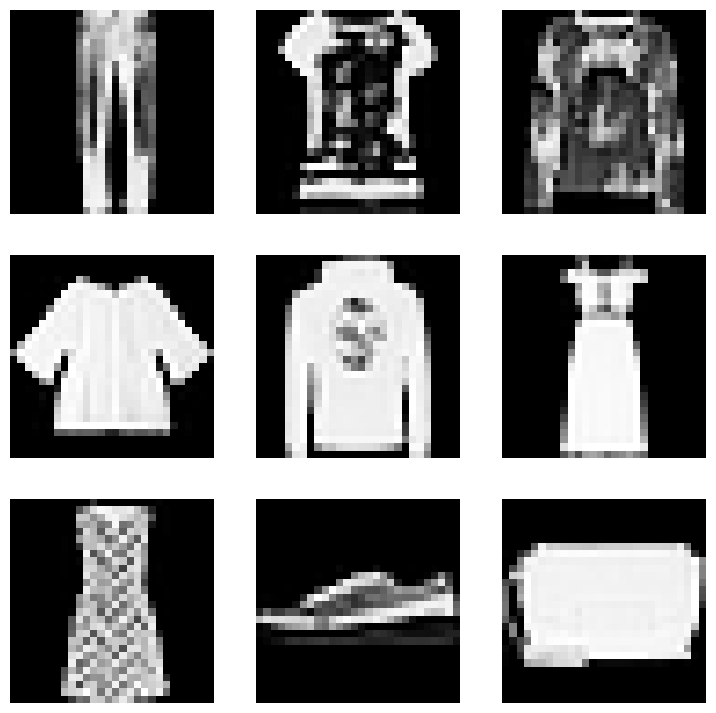

In [5]:
plt.figure(figsize=(9, 9))

randSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[randSamples[i]], cmap="Greys_r")
    plt.axis("off")

plt.show()

## 5. Preprocess the Data
- We combine training and testing since this is not a classification problem rather this is trying to make a system that generates pictures of clothes in general

In [6]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32")/255

## 6. Defining the VAE
- We will make use of keras to construct our model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

### 6.1 Defining the Sampling Layer
- Also called the bottleneck which contains our z (or latent space)
- Based on the Reparameterization Trick: z = mu + sigma * epsilon
- Instead of log_var instead of var which is useful during training and optimization for loss

In [8]:
# Sampling Layer
class SamplingLayer(layers.Layer):

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

### 6.2 Defining the Encoder
#### Sequential Model using Keras
- We use 2 Conv2D layers. The 1st layer extracts low-level features such as edges and textures.
- 2nd Layer extracts higher-level patterns by combining low-level features.
- The 3rd layer converts the 2D feature maps into a 1D vector for input to dense layers for the purpose of preparing data for fully connected layers.
- Finally a fully connected layer with 256 outputs that larns high-level representations from extracted features.

In [9]:
def buildEncoder(latentDim, encoderInputs):

    # Given a batch of images the convolutional block extracts the features
    l1 = keras.models.Sequential([
        layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
        layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
        layers.Flatten(),
        layers.Dense(256, activation="relu")
    ])

    # pass the inputs through the convolutional block
    x = l1(encoderInputs)

    # a dedicated layer to lean and mean in parallel
    mean = layers.Dense(latentDim, name="z_mean")(x)

    # a dedicated layer to lean variance in parallel
    log_var = layers.Dense(latentDim, name="z_log_var")(x)

    z = SamplingLayer()([mean, log_var])

    return keras.Model(encoderInputs, [mean, log_var, z], name="encoder")

encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

I0000 00:00:1742389887.364127    5289 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256)       │    878,144 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (SamplingLayer)     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

### 6.3 Defining the Decoder
- We first transform the latent vector into a shape suitable for upsampling.
- 2nd Layer reshapes the 1D output from the previous Dense layer into a 3D feature map of shape (7,7,64).
-- Purpose: To convert the latent representation into a spatial representation, preparing it for convolutional layers.
- The 3rd layer is the first Transposed Convolution Layer that upsamples the feature map from 7×7 to 14×14, increasing spatial resolution.
- The 4rth layer is the second Transposed Convolution Layer that further refines the upsampled image, increasing its size to 28×28.
- Finally the output layer that produces a grayscale image of shape (28,28,1)

In [10]:
def buildDecoder(latentInputs):

    l1 = keras.models.Sequential([
        layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
        layers.Reshape((7,7,64)),
        layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
        layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
        layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
    ])

    return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# build actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

/home/rkane/vae/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │       157,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Loss Functions
- We use 2 loss functions:
-- Reconstruction loss which uses binary crossentropy
-- and Kullback–Leibler divergence
- Total loss is defined as reconstruction_loss + (kl_weight x kl_loss)
- kl_weight is a hyperparameter

In [11]:
def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstructed),
            axis=(1, 2)
        )
    )

In [12]:
def klDivergenceLoss(mean, log_var):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)),
            axis=1
        )
    )

In [13]:
def calcTotalLoss(data, reconstructed, mean, log_var):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(mean, log_var)
    klWeight = 3.0
    return loss1, loss2, loss1 + klWeight * loss2

## 8. Overriding Keras Model train_step
- Since we are defining our own loss function we also need to change the keras train_step method

In [14]:
# Overriding train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # register total loss as an observable metric in the model training history
        self.totalLossTracker = keras.metrics.Mean(name="total_loss")
        self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
        self.klLossTracker = keras.metrics.Mean(name="kl_loss")

    # Observable metrics
    @property
    def metrics(self):
        return [
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker
        ]

    # Calculate loss + calculate gradients + update weights
    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, mean, log_var)
        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return {
            "total_loss": self.totalLossTracker.result(),
            "ce_loss": self.ceLossTracker.result(),
            "kl_loss": self.klLossTracker.result()
        }

## 9. Instantiate and Train the Model
- This also saves the model and training history under the 'models' directory
- If a model is already saved, no need to train

In [15]:
import os
import json
from tensorflow.keras.models import load_model

model_path = "models/vae_model.keras"
history_path = "models/history.json"
redo = False

if os.path.exists(model_path) and not redo:
    print("Loading saved model...")

    # Load encoder and decoder separately
    encoder = load_model("models/encoder_model.keras", custom_objects={"SamplingLayer": SamplingLayer})
    decoder = load_model("models/decoder_model.keras")

    # Recreate the VAE instance
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

    # Load training history if available
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            history = json.load(f)
    else:
        history = None  # No training history available

else:
    print("Training new model...")

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

    # Train the model
    history = vae.fit(dataset, epochs=50, batch_size=128)

    # Save training history
    with open(history_path, "w") as f:
        json.dump(history.history, f)

    # Save individual components
    vae.encoder.save("models/encoder_model.keras")
    vae.decoder.save("models/decoder_model.keras")

    # Save the full VAE model
    vae.save(model_path)

Loading saved model...


## 10. Checking training loss

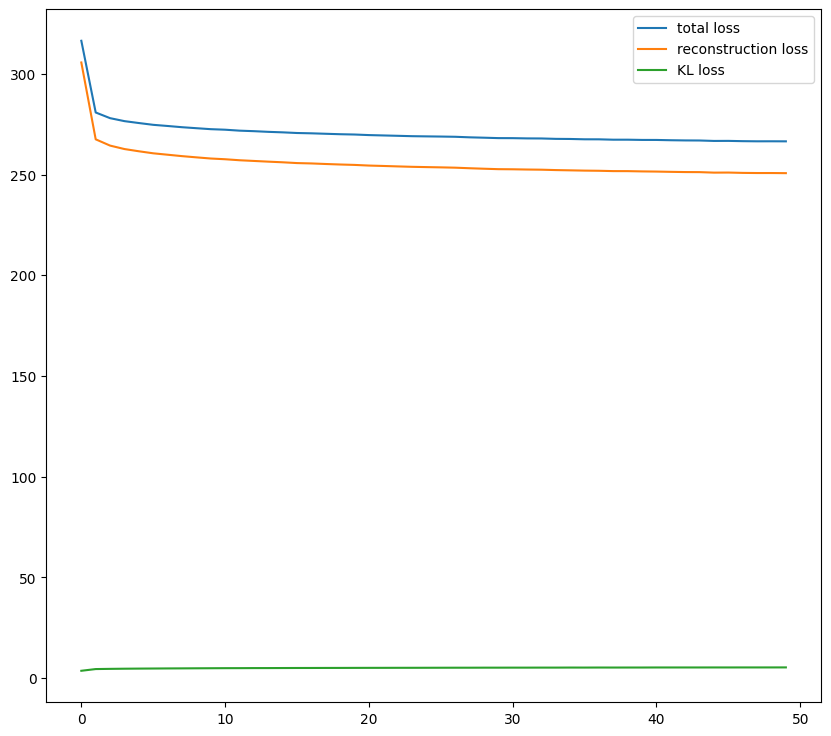

In [17]:
plt.figure(figsize=(10, 9))

# Handle both cases: history object vs. loaded dictionary
if hasattr(history, "history"):  # If history is a keras History object
    history_data = history.history
else:  # If history is loaded from JSON
    history_data = history

plt.plot(history_data.get('total_loss'), label="total loss")
plt.plot(history_data.get('ce_loss'), label="reconstruction loss")
plt.plot(history_data.get('kl_loss'), label="KL loss")

plt.legend()
plt.show()

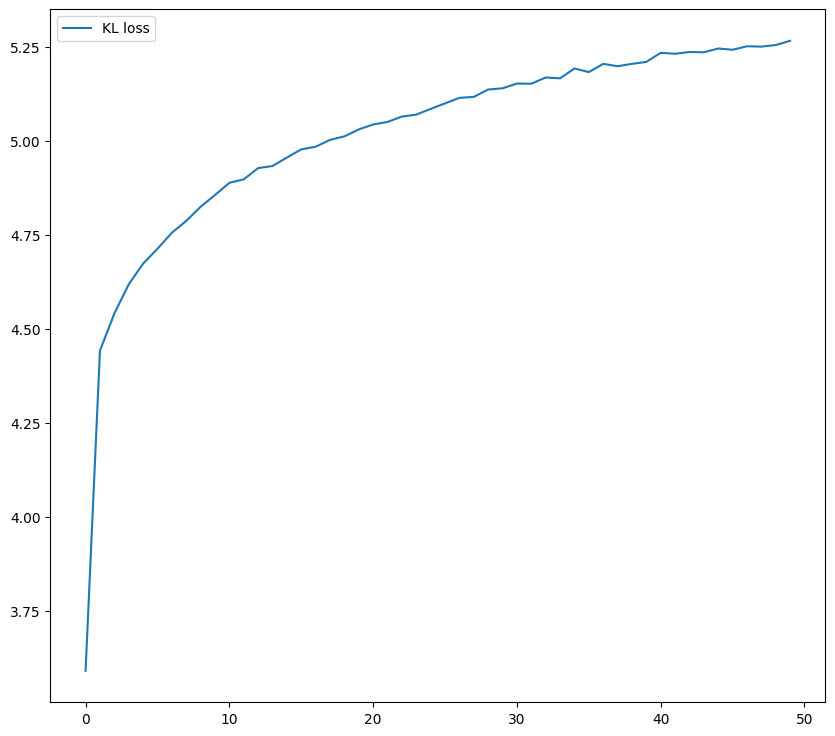

In [19]:
plt.figure(figsize=(10, 9))

# Handle both cases: history object vs. loaded dictionary
if hasattr(history, "history"):  # If history is a keras History object
    history_data = history.history
else:  # If history is loaded from JSON
    history_data = history

plt.plot(history_data.get('kl_loss'), label="KL loss")
plt.legend()
plt.show()

### KL loss shows an upward trend w/c is bad for loss although it started plateau.
- Possible changes:
    - Tweaking KL_Weight
    - More epochs to see if loss goes down further

### Total Loss and Reconstruction Loss only improves on the 1st few epochs.
- Possible changes:
    - Increase batch size to avoid cases where training is stuck on a local minima
    - Change strides to 1

## 11. Synthesizing New Samples (Exploratory Part)
- To check if our VAE works, we generate new samples given a latent vector

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


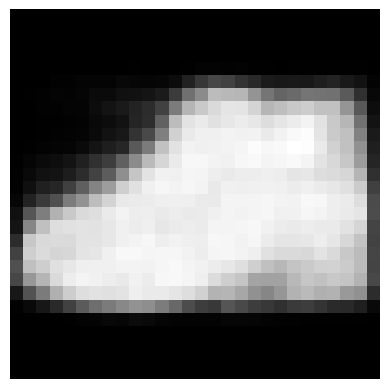

In [71]:
import numpy as np

latent_vector1 = np.array([[1, 1]], dtype=np.float32)
latent_vector2 = np.array([[-1, -1]], dtype=np.float32)
synth1 = vae.decoder.predict(latent_vector1)
synth2 = vae.decoder.predict(latent_vector2)

# Remove extra dimensions if needed
synth1 = synth1.squeeze()  # Shape should become (28, 28)
synth2 = synth2.squeeze()

# Display the generated image
plt.axis('off')
plt.imshow(synth1, cmap="Greys_r")
plt.show()

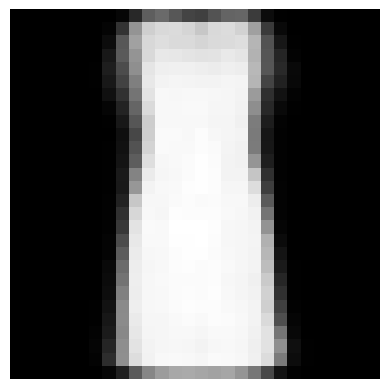

In [72]:
# Display the generated image
plt.axis('off')
plt.imshow(synth2, cmap="Greys_r")
plt.show()

### 11.2 Generate even more samples from random latent vectors

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


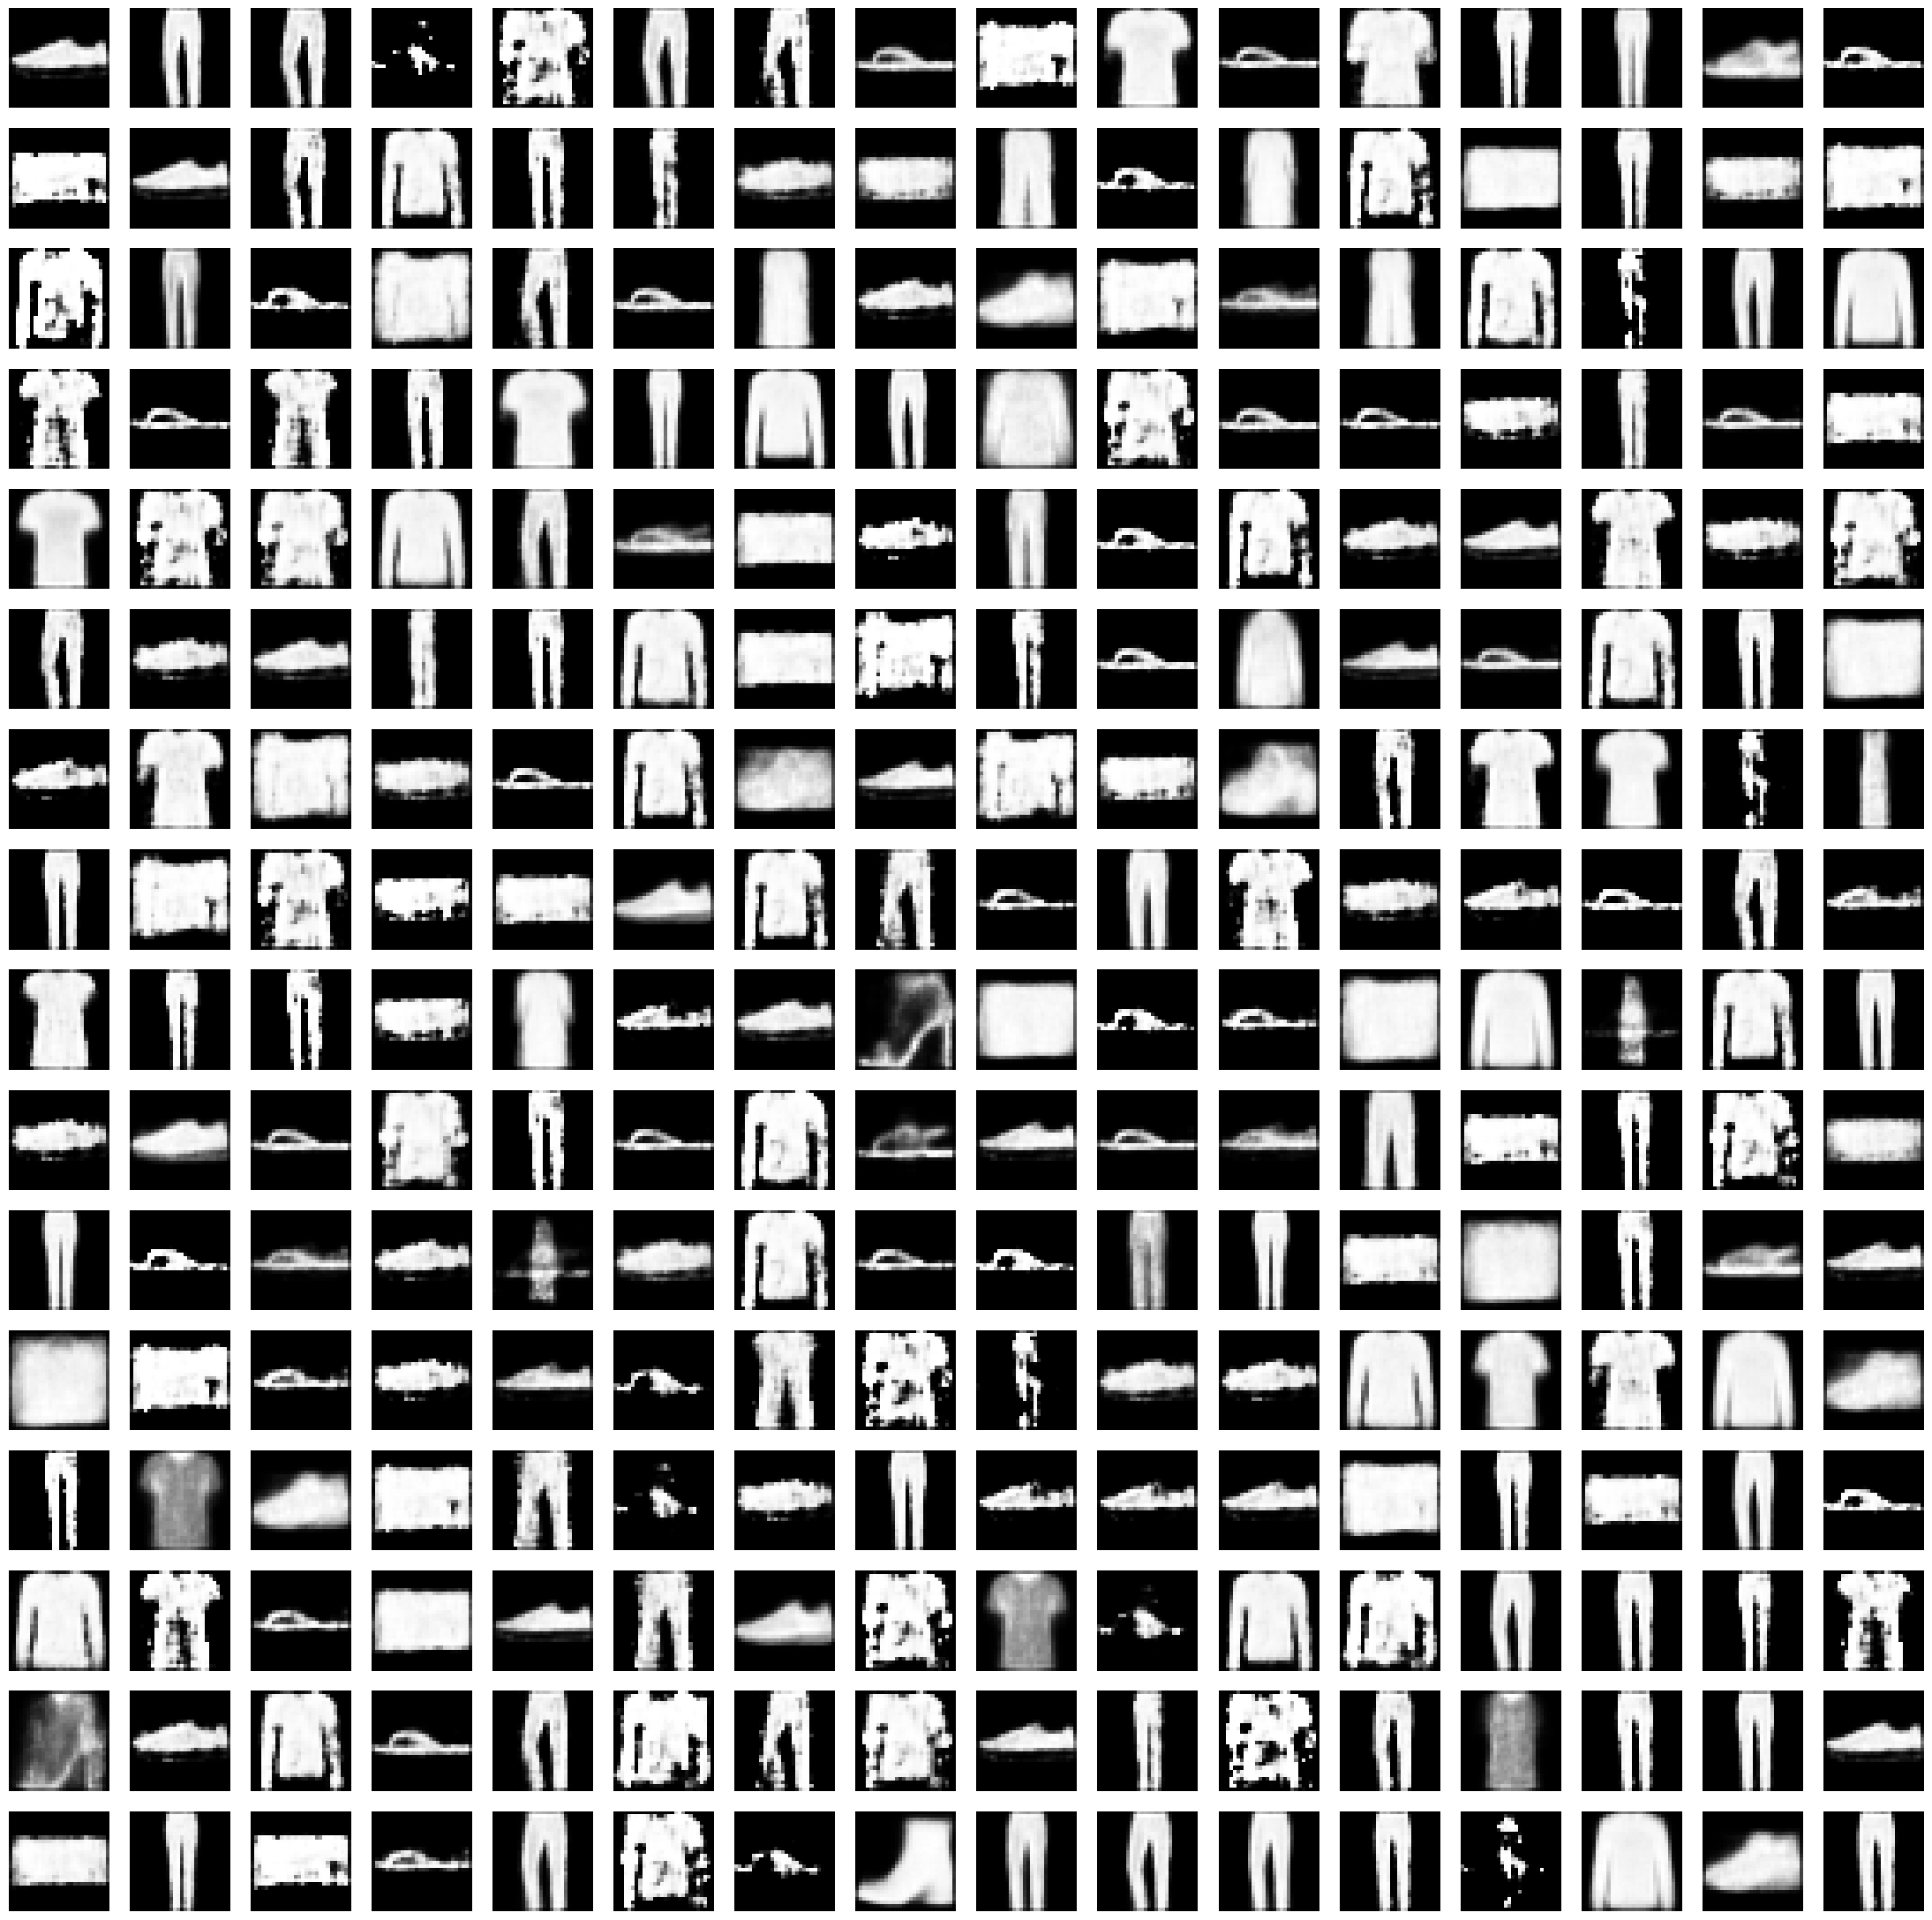

In [22]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)
plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show()

### 11.3 Check comparisson of X_hat VS X
- We check if a given input produces a close reconstruction

In [23]:
idx = 1280
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)

_, _, z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


/home/rkane/vae/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_2
Received: inputs=('Tensor(shape=(1, 2))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


array([[-0.9481624, -0.9817871]], dtype=float32)

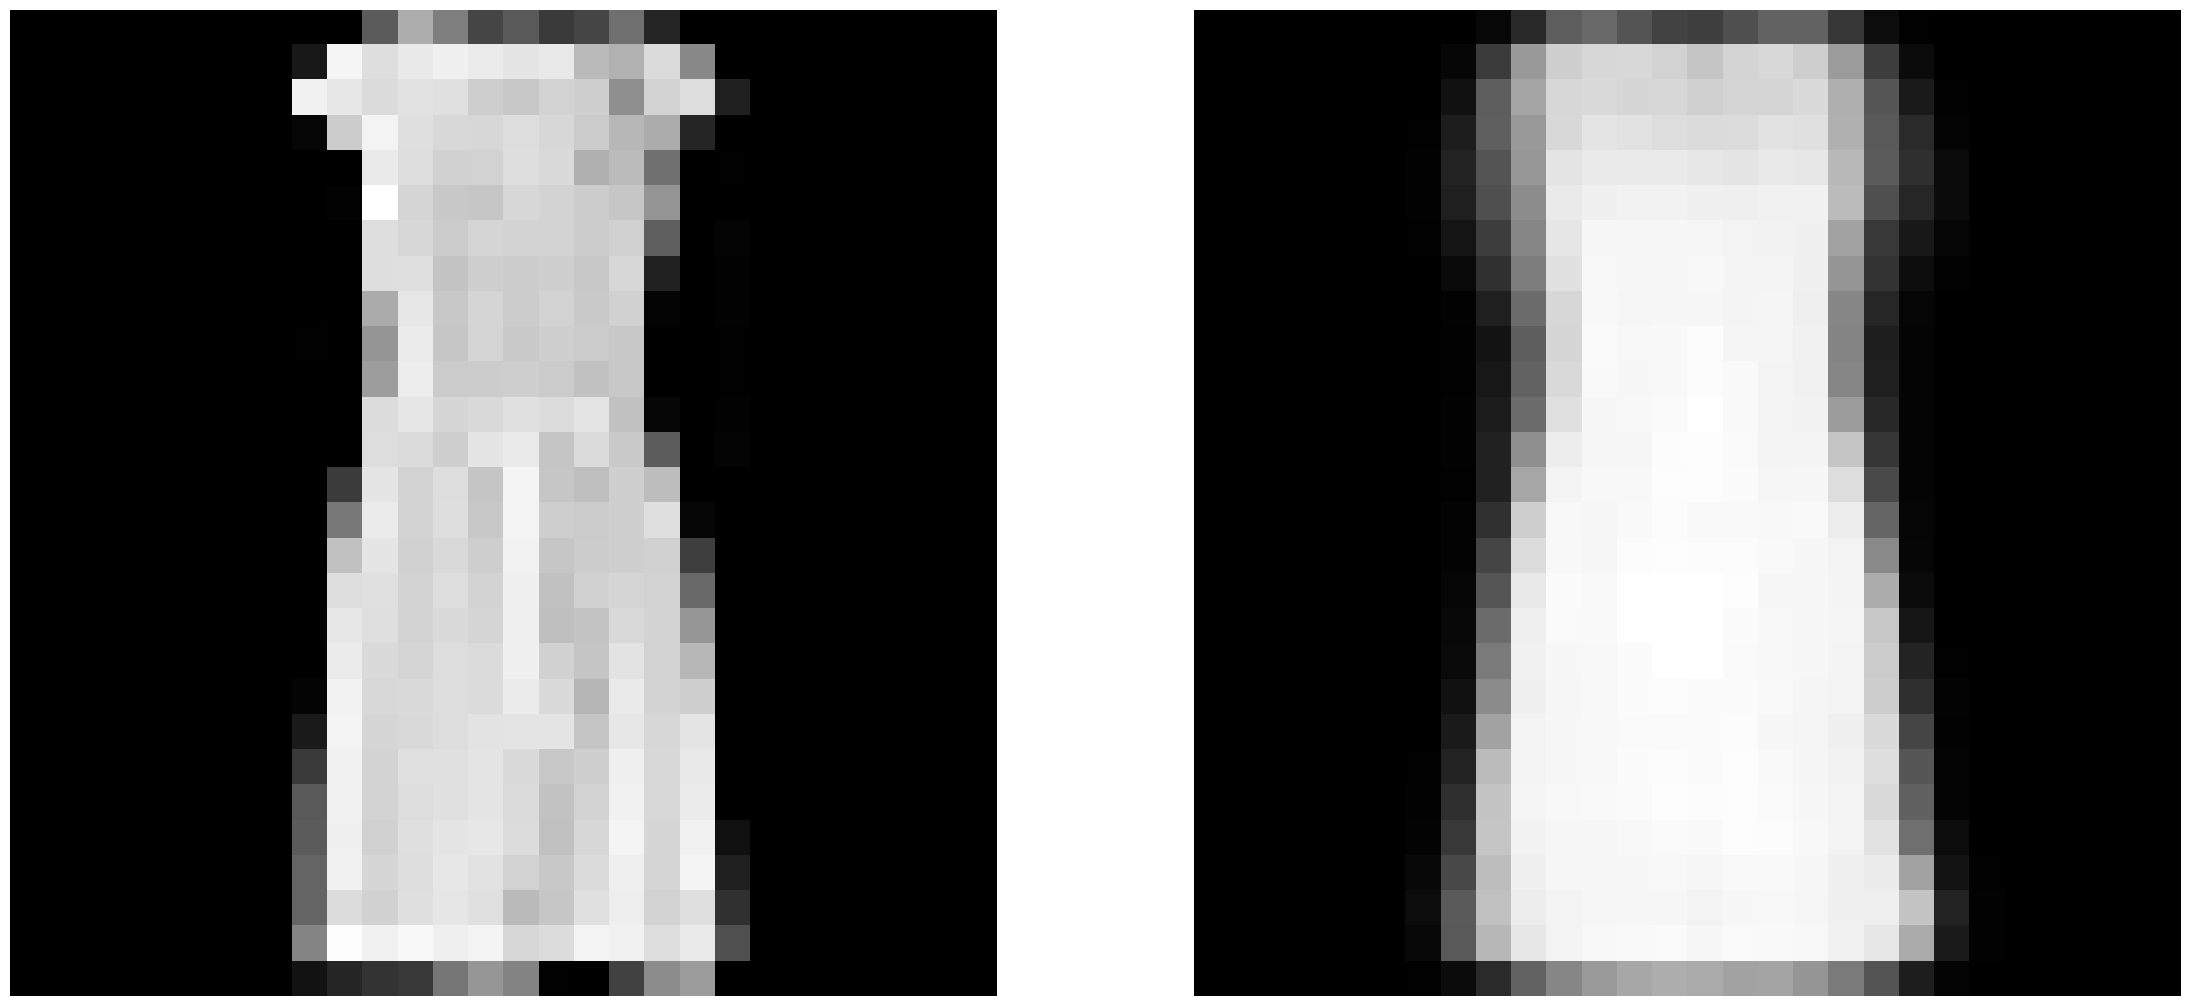

In [24]:
plt.figure(figsize=(28, 28))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")

plt.show()

### 11.4 Visualize Probability Distributions by Known Classifications of the Dataset
- We use the labels from the dataset and plot the means and variances across the entire dataset

2025-03-19 21:15:28.184150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



2172/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-03-19 21:15:34.445661: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads



2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


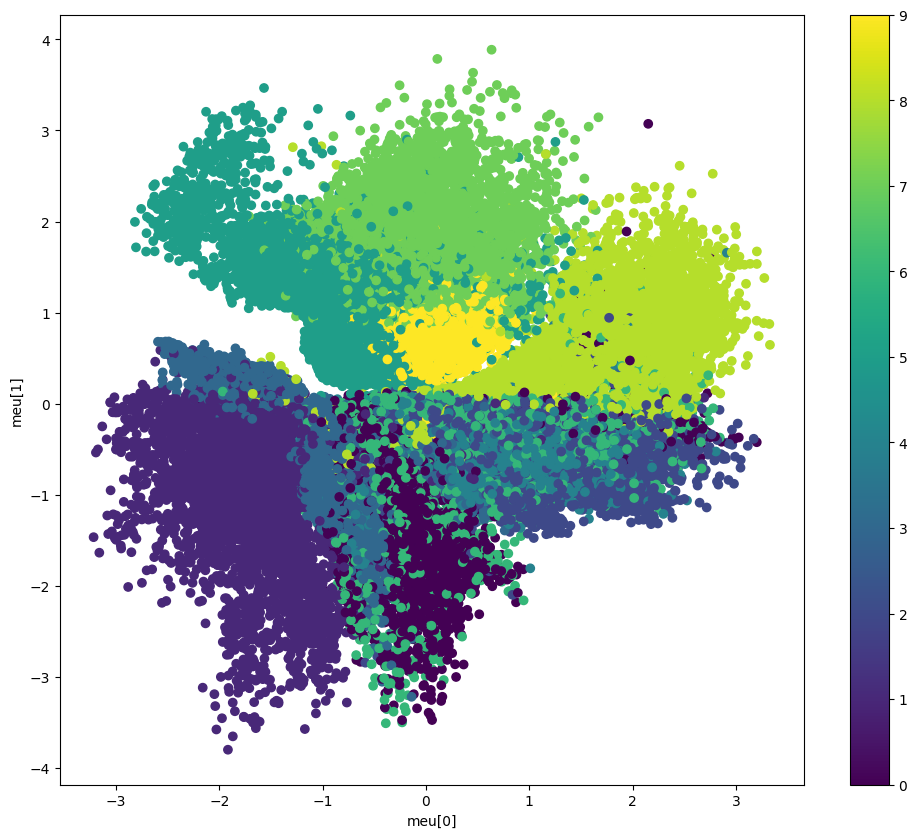

In [25]:
# Unsupervised Learning
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12,10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show()

## 12. Generate Frames for X ∈ ^(1 x 72 x 28 x 28)
- To generate frames for x_1 and x_2, we make use of decoder to synthesize new samples
- To simulate key frames where frames are similar, we add a small noise

In [32]:
num_frames = 72
latent_dim = 2

In [85]:
import numpy as np

# Define mean latent vectors for x1 and x2
x1_base = np.random.normal(loc=0, scale=1, size=(1, latent_dim))  # Single latent vector for x1
x2_base = np.random.normal(loc=0, scale=1, size=(1, latent_dim))  # Single latent vector for x2

# Add small variations to make frames of x1 similar to each other
variation_scale = 0.2  # Small noise to keep frames similar
x1_z_samples = x1_base + np.random.normal(loc=0, scale=variation_scale, size=(num_frames, latent_dim))
x2_z_samples = x2_base + np.random.normal(loc=0, scale=variation_scale, size=(num_frames, latent_dim))

# Decode latent vectors to generate frames
x1 = vae.decoder.predict(x1_z_samples)
x2 = vae.decoder.predict(x2_z_samples)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


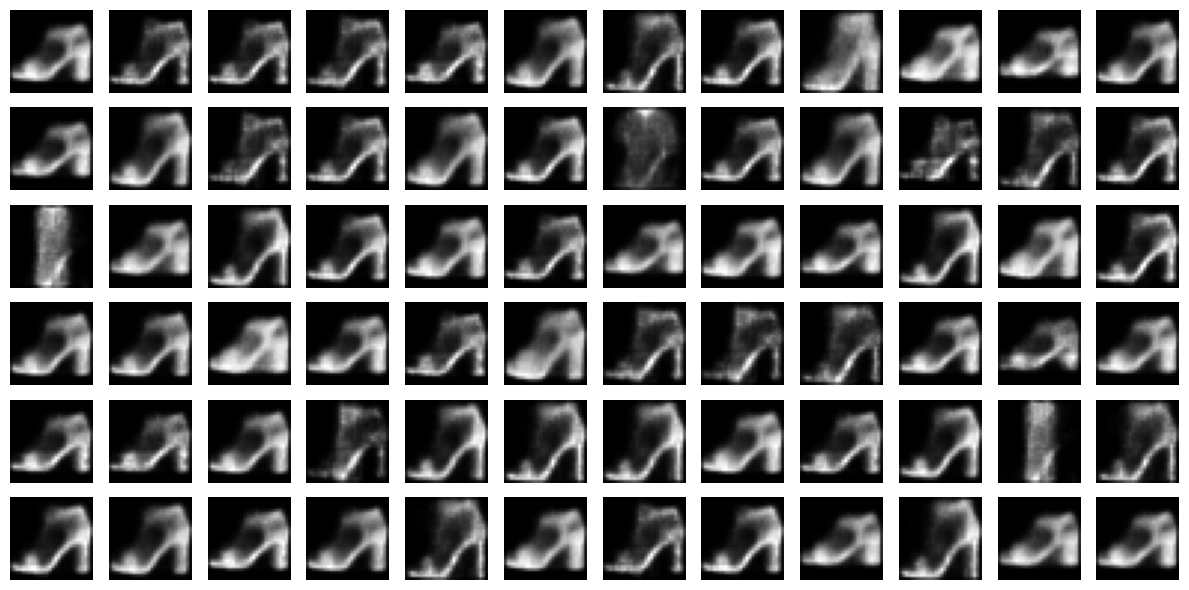

In [86]:
# Generate random latent vectors (Gaussian distribution)
# x1_z_samples = np.random.normal(size=(num_frames, latent_dim))
# x2_z_samples = np.random.normal(size=(num_frames, latent_dim))

# Decode latent vectors to generate frames
# x1 = vae.decoder.predict(x1_z_samples)
# x2 = vae.decoder.predict(x2_z_samples)

# Plot synthesized frames for x1
fig, axes = plt.subplots(6, 12, figsize=(12, 6))  # 6 rows x 12 columns
axes = axes.flatten()

for i in range(num_frames):
    axes[i].imshow(x1[i], cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

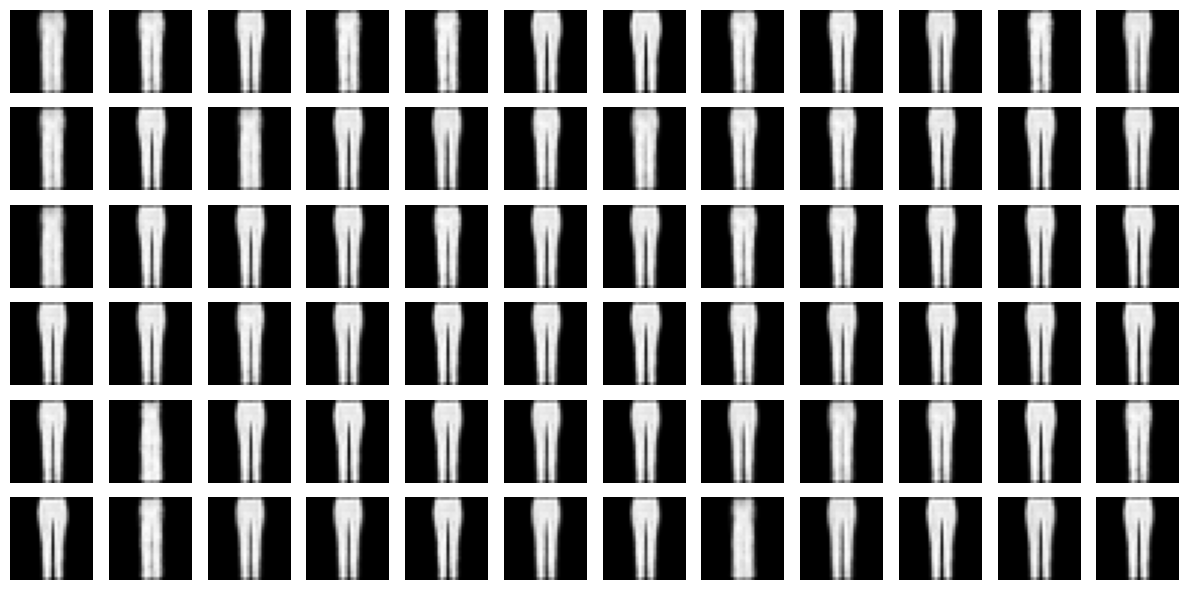

In [87]:
# Plot synthesized frames for x2
fig, axes = plt.subplots(6, 12, figsize=(12, 6))  # 6 rows x 12 columns
axes = axes.flatten()

for i in range(num_frames):
    axes[i].imshow(x2[i], cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [88]:
# Encode all 72 frames of x1
z1_list = []

for i in range(72):
    _, _, z = vae.encoder.predict(np.expand_dims(x1[i], axis=0))  # Ensure input has batch dim
    z1_list.append(z)

z_x1 = np.vstack(z1_list)  # Shape: (72, latent_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [89]:
# Encode all 72 frames of x2
z2_list = []

for i in range(72):
    _, _, z = vae.encoder.predict(np.expand_dims(x2[i], axis=0))  # Ensure input has batch dim
    z2_list.append(z)

z_x2 = np.vstack(z2_list)  # Shape: (72, latent_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


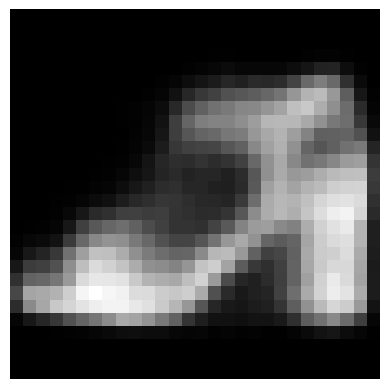

In [90]:
# Decode one of the latent vectors of x1 back into a frame (e.g., the first frame)
synth_frame = vae.decoder.predict(np.expand_dims(z_x1[0], axis=0))

# Display the synthesized frame
plt.imshow(synth_frame[0], cmap="gray")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


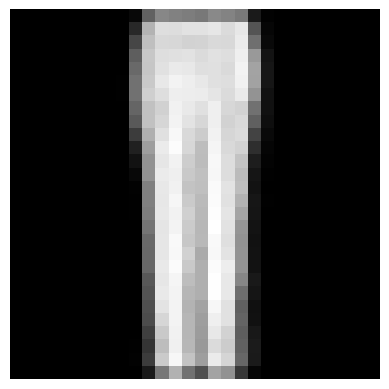

In [91]:
# Decode one of the latent vectors of x2 back into a frame (e.g., the first frame)
synth_frame = vae.decoder.predict(np.expand_dims(z_x2[0], axis=0))

# Display the synthesized frame
plt.imshow(synth_frame[0], cmap="gray")
plt.axis("off")
plt.show()

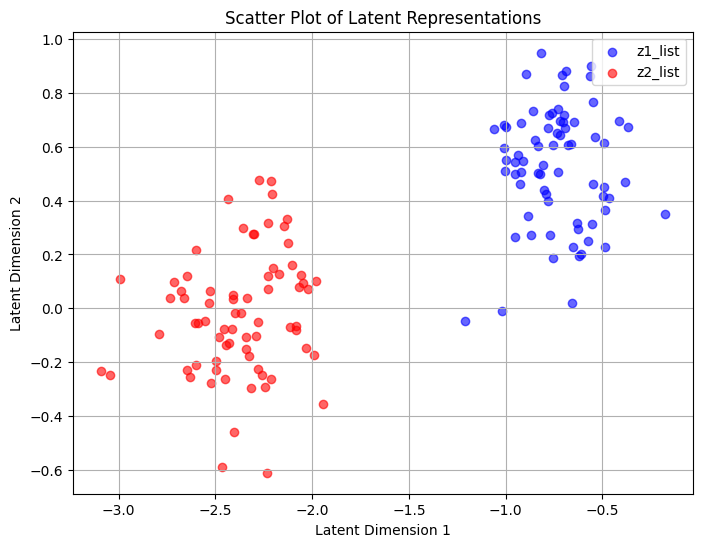

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to arrays and reshape them to (N, 2)
z1_array = np.vstack(z1_list)  # Shape: (N, 2)
z2_array = np.vstack(z2_list)  # Shape: (N, 2)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(z1_array[:, 0], z1_array[:, 1], color='blue', alpha=0.6, label='z1_list')
plt.scatter(z2_array[:, 0], z2_array[:, 1], color='red', alpha=0.6, label='z2_list')

# Labels and title
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Scatter Plot of Latent Representations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [93]:
z3_list = []

# Encode first half of x1 (0 to 35)
for i in range(36):
    _, _, z = vae.encoder.predict(np.expand_dims(x1[i], axis=0))  # Add batch dimension
    z3_list.append(z)

# Encode second half of x2 (36 to 71)
for i in range(36, 72):  
    _, _, z = vae.encoder.predict(np.expand_dims(x2[i], axis=0))  # Add batch dimension
    z3_list.append(z)

# Stack into a single array
z_x3 = np.vstack(z3_list)  # Shape: (72, latent_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

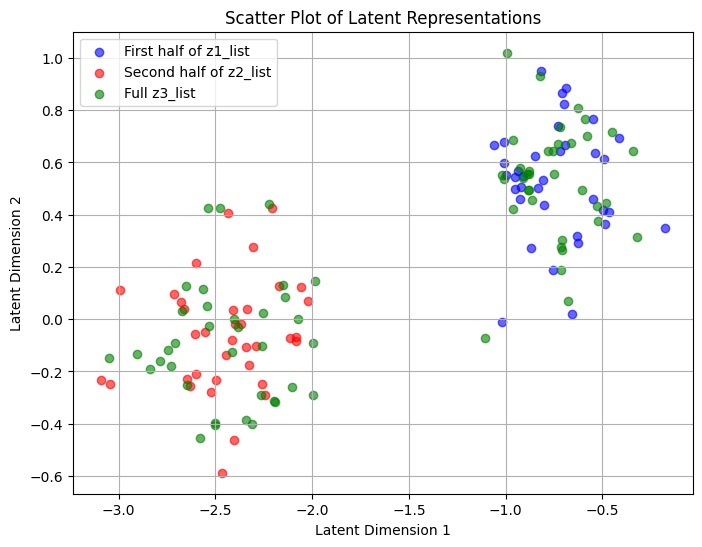

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to arrays and reshape them to (N, 2)
z3_array = np.vstack(z3_list)  # Shape: (N, 2)  # Add z3

N = len(z1_array)  # Total number of frames

# Scatter plot
plt.figure(figsize=(8, 6))

# Plot only the first half of z1
plt.scatter(z1_array[:N//2, 0], z1_array[:N//2, 1], color='blue', alpha=0.6, label='First half of z1_list')

# Plot only the second half of z2
plt.scatter(z2_array[N//2:, 0], z2_array[N//2:, 1], color='red', alpha=0.6, label='Second half of z2_list')

# Plot full z3
plt.scatter(z3_array[:, 0], z3_array[:, 1], color='green', alpha=0.6, label='Full z3_list')

# Labels and title
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Scatter Plot of Latent Representations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()